Luiz Carlos Irber Jr

ECS 253 - Network Theory

UC Davis

In [1]:
%matplotlib inline
import numpy.linalg as LA
import numpy as np

import networkx as nx

MAX_ITERS = 1000

# Question 1

## a

Adjacency matrix:

In [2]:
directed = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0]], dtype='d')
directed

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.]])

Using networkx to draw the graph:

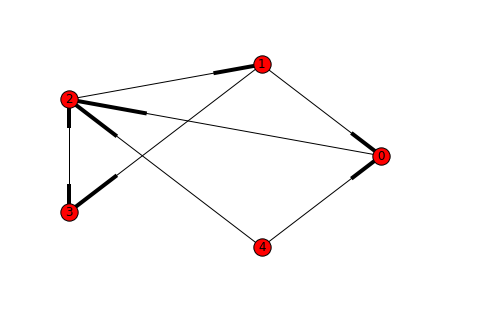

In [3]:
d = nx.DiGraph(directed)
pos = nx.circular_layout(d)
nx.draw(d, pos=pos)
labels = nx.draw_networkx_labels(d, pos=pos)

## b

Define a function to calculate the transition matrix (each row sums to 1)

In [4]:
def transition(m):
    rowsum = np.sum(m, axis=1)
    rowsum[np.where(rowsum == 0)] = 1
    return m / rowsum[:,None]

Calculate the transition matrix $p_d$ for the directed graph:

In [5]:
p_d = transition(directed)
p_d

array([[ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0.5,  0. ],
       [ 0. ,  0.5,  0. ,  0.5,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ]])

Three methods for calculating the steady-state probability:

- `stn`: Solve the linear system
- `stn_mult`: use matrix multiplication to the _niters_ power (using $\lceil \log_2{niters} \rceil$ iterations)
- `simulate_steady`: simulate a random walk _nsteps_ long. If a vertex doesn't have any edge pointing to another vertex, select a random vertex to continue the walk.

I implemented three different methods to check if their results agree with each other.

In [6]:
def stn(p):
    n = p.shape[0]
    imp = np.eye(n) - p.transpose()
    imp[-1] = np.ones(n)
    rhs = np.zeros(n)
    rhs[-1] = 1
    return np.linalg.solve(imp, rhs)


def stn_mult(p, niters=MAX_ITERS):
    d = p @ p
    for i in range(int(np.ceil(np.log2(niters)))):
        d = d @ p
    return np.mean(d, axis=0)


def simulate_steady(p, nsteps=MAX_ITERS):
    n = p.shape[0]
    visits = np.zeros(n)
    next_node = np.random.choice(range(n))
    for i in range(nsteps):
        possible_nodes = np.where(p[next_node] != 0)[0]
        next_node = None
        if possible_nodes.size:  # check if possible_nodes is not empty
            next_node = np.random.choice(possible_nodes)

        if next_node is None:
            next_node = np.random.choice(range(n))
        else:
            visits[next_node] += 1

    return np.round(visits / nsteps, 3)

In [7]:
stn(p_d)

array([ 0.1,  0.2,  0.4,  0.3, -0. ])

In [8]:
sols = []
for i in range(1000):
    sols.append(simulate_steady(p_d, 1000))
av = np.mean(sols, axis=0)
av, sum(av)

(array([ 0.099763,  0.199721,  0.400188,  0.300328,  0.      ]),
 0.999999999999999)

In [9]:
stn_mult(p_d)

array([ 0.1      ,  0.1984375,  0.403125 ,  0.2984375,  0.       ])

The steady-state probability is:

$[0.1, 0.2, 0.4, 0.3, 0]$

## c

Adjacency matrix and transition matrix $p_u$:

In [10]:
undirected = np.array([
    [0, 1, 1, 0, 1],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 1, 1],
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0]], dtype='d')

p_u = transition(undirected)
p_u

array([[ 0.        ,  0.33333333,  0.33333333,  0.        ,  0.33333333],
       [ 0.33333333,  0.        ,  0.33333333,  0.33333333,  0.        ],
       [ 0.25      ,  0.25      ,  0.        ,  0.25      ,  0.25      ],
       [ 0.        ,  0.5       ,  0.5       ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.5       ,  0.        ,  0.        ]])

Using networkx to draw the graph:

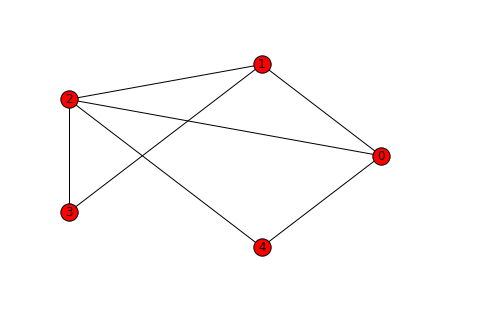

In [11]:
und = nx.Graph(undirected)
pos = nx.circular_layout(und)
nx.draw(und, pos=pos)
labels = nx.draw_networkx_labels(und, pos=pos)

Using the same three methods as before:

In [12]:
stn(p_u)

array([ 0.21428571,  0.21428571,  0.28571429,  0.14285714,  0.14285714])

In [13]:
sols = []
for i in range(1000):
    sols.append(simulate_steady(p_u, 1000))
av = np.mean(sols, axis=0)
av, sum(av)

(array([ 0.214491,  0.214342,  0.285529,  0.1429  ,  0.142738]),
 1.0000000000000011)

In [14]:
stn_mult(p_u, 1000)

array([ 0.21428571,  0.21428571,  0.28568987,  0.14286935,  0.14286935])

The steady-state probability is different, and proportional to the degree of the node (nodes $1$ and $2$ have degree 3, $4$ and $5$ have degree 2, $3$ has degree 4):

$[0.214, 0.214, 0.286, 0.143, 0.143]$

# Question 2

## a

$k=1: n_{1, t+1} = n_{1,t} + 1 - \frac{1}{t}n_{1,t}$

$k>1: n_{k, t+1} = n_{k, t} + \frac{1}{t}n_{k-1,t} - \frac{1}{t}n_{k,t}$

## b

$k=1: (t+1)p_{1,t+1} = (t-1)p_{1,t} + 1$

$k>1: (t+1)p_{k,t+1}=(t-1)p_{k,t} + p_{k-1,t}$

## c

**For k=1:**

$(t+1)p_1 = (t-1)p_1 + 1$

$p_1 = \frac{1}{2}$

**For k > 1**

$(t+1)p_k = (t-1)p_k + p_{k-1}$

$2p_k = p_{k-1}$

$p_k = \frac{p_{k-1}}{2}$

## d

$p_1 = \frac{1}{2}$

$p_2 = \frac{p_1}{2} = \frac{1}{4}$

$p_3 = \frac{p_2}{2} = \frac{1}{8}$

$p_k = \frac{1}{2^k} = 2^{-k}$